# Money-flow index (MFI) volume-indicator example trading strategy

- This is an example strategy for volume-based indicators [Money Flow Index](https://tradingstrategy.ai/glossary/money-flow-index-mfi) ([MFI](https://tradingstrategy.ai/glossary/money-flow-index-mfi))
- Uses Binance daily ETH feed
- Long only
- The strategy is not profit making, but only to demostrate how to use volume-based indicators in your strategies
  - We see that the strategy equity curve follows ETH buy-and-hold, but with less success
- We recommend checking README and reading the earlier example notebooks first, as this notebook has more sparse comments
  on the sections that have been covered earlier

# Set up

Set up Trading Strategy data client.


In [47]:
from tradeexecutor.utils.notebook import setup_charting_and_output
from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Strategy parameters define the fixed and grid searched parameters

In [48]:
from tradingstrategy.chain import ChainId
import datetime

from tradeexecutor.strategy.default_routing_options import TradeRouting
from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.parameters import StrategyParameters


class Parameters:

    id = "eth-mfi" # Used in cache paths

    cycle_duration = CycleDuration.cycle_1d
    candle_time_bucket = TimeBucket.d1  
    allocation = 0.98   

    # MFI used to identify overbought/oversold
    mfi_length = 14  # days
    mfi_entry_level = 40
    mfi_exit_level = 80

    # ADX used for the regime filter
    adx_length = 14  
    adx_filter_threshold = 25

    #
    # Live trading only
    #
    chain_id = ChainId.polygon
    routing = TradeRouting.default  
    required_history_period = datetime.timedelta(days=14 + 1)

    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2021, 1, 1)
    backtest_end = datetime.datetime(2024, 5, 1)
    stop_loss_time_bucket = TimeBucket.h1
    backtest_trading_fee = 0.0005
    initial_cash = 10_000

parameters = StrategyParameters.from_class(Parameters) 



# Trading pairs and market data


In [49]:
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse, load_partial_data
from tradingstrategy.client import Client
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.utils.binance import create_binance_universe
from tradeexecutor.strategy.universe_model import UniverseOptions

trading_pairs = [
    (ChainId.centralised_exchange, "binance", "ETH", "USDT"),
]

def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    """Create the trading universe.

    - In this example, we load all Binance spot data based on our Binance trading pair list.
    """

    # Backtesting - load Binance data
    strategy_universe = create_binance_universe(
        [f"{p[2]}{p[3]}" for p in trading_pairs],
        candle_time_bucket=Parameters.candle_time_bucket,
        stop_loss_time_bucket=Parameters.stop_loss_time_bucket,
        start_at=universe_options.start_at,
        end_at=universe_options.end_at,
        trading_fee_override=Parameters.backtest_trading_fee,
    )
    return strategy_universe


strategy_universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)


# Indicators

- We use `pandas_ta` Python package to calculate technical indicators
- These indicators are precalculated and cached on the disk

In [50]:
import pandas as pd
import pandas_ta

from tradeexecutor.analysis.regime import Regime
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradingstrategy.utils.groupeduniverse import resample_candles


def create_indicators(
    timestamp: datetime.datetime | None,
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    indicators = IndicatorSet()

    # Money Flow Index
    indicators.add(
        "mfi",
        pandas_ta.mfi,
        {"length": parameters.mfi_length},
        IndicatorSource.ohlcv,
    )
        
    return indicators

# Trading algorithm

- Describe out trading strategy as code

In [51]:
from tradeexecutor.state.visualisation import PlotKind
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInput


def decide_trades(
    input: StrategyInput,
) -> list[TradeExecution]:

    # 
    # Decidion cycle setup.
    # Read all variables we are going to use for the decisions.
    #
    parameters = input.parameters
    position_manager = input.get_position_manager()
    state = input.state
    timestamp = input.timestamp
    indicators = input.indicators
    strategy_universe = input.strategy_universe

    pair = strategy_universe.get_single_pair()
    cash = position_manager.get_current_cash()

    #
    # Indicators
    #

    close_price = indicators.get_price()  # Price the previous 15m candle closed for this decision cycle timestamp
    mfi = indicators.get_indicator_value("mfi")  
    volume = indicators.get_price(column="volume")
 
    if None in (mfi, close_price):
        # Not enough historic data,
        # cannot make decisions yet
        return []
            
    #
    # Trading logic
    #

    trades = []

    # Check for open condition - is the price breaking out
    #
    if not position_manager.is_any_open():        
        if mfi < parameters.mfi_entry_level:
            trades += position_manager.open_spot(
                pair,
                value=cash * parameters.allocation,
                #stop_loss_pct=parameters.stop_loss_pct,             
            )
    else:
        # Check for close condition
        if mfi > parameters.mfi_exit_level:
            trades += position_manager.close_all()
            
    # Visualisations
    #
    if input.is_visualisation_enabled():
        visualisation = state.visualisation
        visualisation.plot_indicator(timestamp, "MFI", PlotKind.technical_indicator_detached, mfi)
        visualisation.plot_indicator(timestamp, "Volume", PlotKind.technical_indicator_detached, volume)

    return trades  # Return the list of trades we made in this cycle

# Backtest

- Run the backtest

In [52]:
from tradeexecutor.backtest.backtest_runner import run_backtest_inline

result = run_backtest_inline(
    name=parameters.id,
    engine_version="0.5",
    decide_trades=decide_trades,
    create_indicators=create_indicators,
    client=client,
    universe=strategy_universe,
    parameters=parameters,
    strategy_logging=False,
    max_workers=1
)

state = result.state

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

Reading cached indicators mfi for 1 pairs, using 8 threads:   0%|          | 0/1 [00:00<?, ?it/s]

Using indicator cache /Users/moo/.cache/indicators/centralised-exchange_1d_ETH-USDT_2021-01-01-2024-05-01_nff


  0%|          | 0/105062400 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 19 trades


# Equity curve

- Equity curve shows how your strategy accrues value over time
- A good equity curve has a stable ascending angle
- Benchmark against MATIC buy and hold

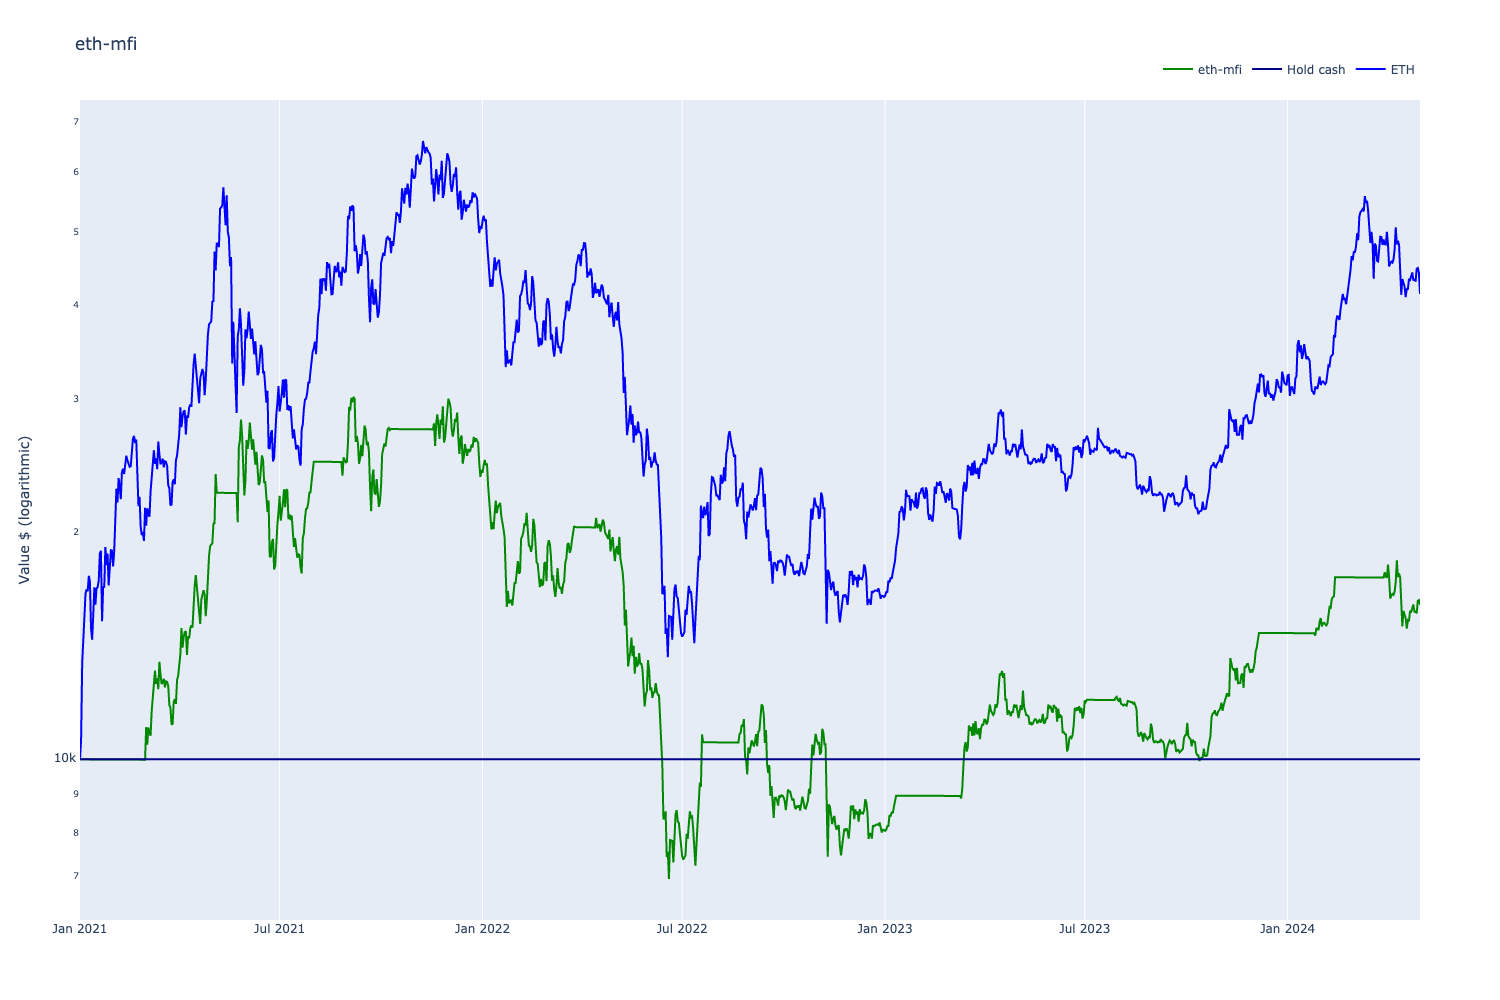

In [53]:
import pandas as pd
from tradeexecutor.analysis.multi_asset_benchmark import get_benchmark_data
from tradeexecutor.visual.benchmark import visualise_equity_curve_benchmark

benchmark_indexes = get_benchmark_data(
    strategy_universe,
    cumulative_with_initial_cash=state.portfolio.get_initial_cash()
)

fig = visualise_equity_curve_benchmark(
    name=state.name,
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_cash(),
    benchmark_indexes=benchmark_indexes,
    height=800,
    log_y=True,
)

fig.show()

# Technical indicator and trade visualisation

- Draw the technical indicators we filled in in `decide_trades()`
- Show the made trades on the price chart for a single trading pair
- You need to zoom in to see the bollinger bands, as the default chart width is full multi-year study.
  However the default notebook chart mode is static images, as interactive images are a bit slow on Github Codespaces.

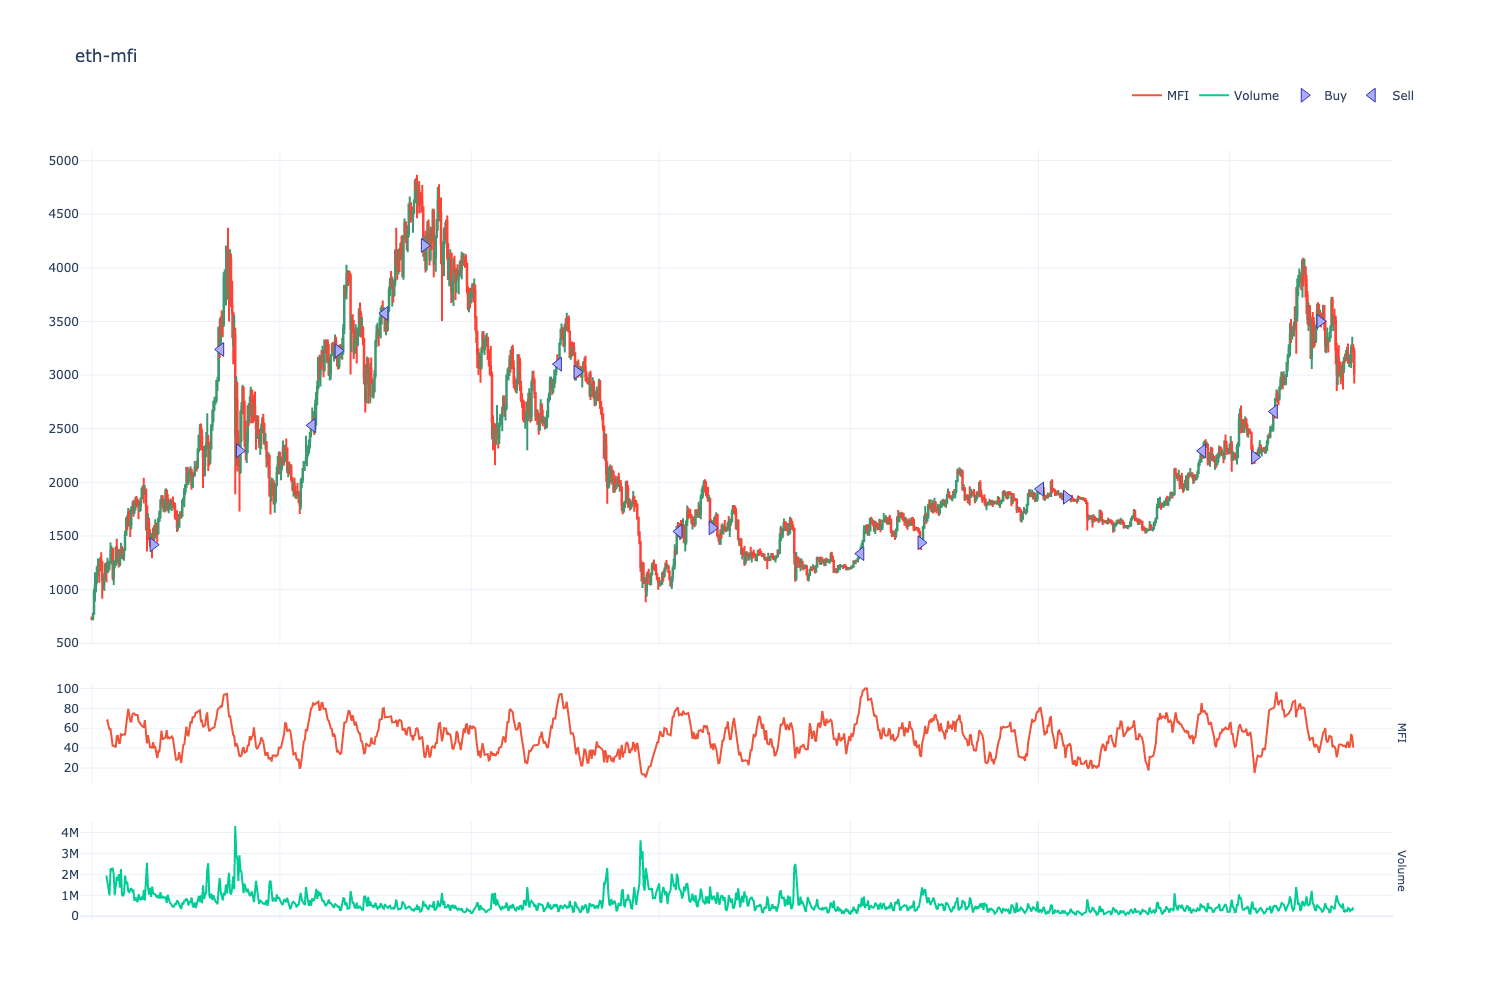

In [54]:
from tradeexecutor.visual.single_pair import visualise_single_pair
from tradingstrategy.charting.candle_chart import VolumeBarMode

start_at, end_at = state.get_strategy_start_and_end()   # Limit chart to our backtesting range

figure = visualise_single_pair(
    state,
    execution_context=notebook_execution_context,
    candle_universe=strategy_universe.data_universe.candles,
    start_at=start_at,
    end_at=end_at,
    volume_bar_mode=VolumeBarMode.hidden,
    volume_axis_name="Volume (USD)",
    height = 1000,
)

figure.show()

# Performance metrics

- Display portfolio performance metrics
- Compare against buy and hold matic using the same initial capital

In [55]:
from tradeexecutor.analysis.multi_asset_benchmark import compare_strategy_backtest_to_multiple_assets

compare_strategy_backtest_to_multiple_assets(
    state,
    strategy_universe,
    display=True,
)

,Strategy,ETH
Start Period,2021-01-01,2021-01-01
End Period,2024-04-30,2024-04-30
Risk-Free Rate,0.0%,0.0%
Time in Market,71.0%,100.0%
Cumulative Return,60.25%,313.5%
CAGR﹪,15.22%,53.18%
Sharpe,0.54,0.93
Prob. Sharpe Ratio,83.9%,95.52%
Sortino,0.79,1.37
Sortino/√2,0.56,0.97


# Trading statistics

- Display summare about made trades

In [56]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)
summary = analysis.calculate_summary_statistics()
display(summary.to_dataframe())

,0
Trading period length,1123 days 0 hours
Return %,60.25%
Annualised return %,19.58%
Cash at start,"$10,000.00"
Value at end,"$16,025.11"
Time in market,70.88%
Time in market volatile,66.79%
Trade volume,"$320,922.50"
Position win percent,66.67%
Total positions,9
